# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


## Problem Statement

The problem is simple: we want to make better purchasing offers to Starbucks' customers. For this, we can use customer's past behaviour to find patterns and try to be more assertive. As given by the Udacity's Starbucks Project Overview, the basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer. In other words, this is a classification problem where the model takes user behaviour data as input and produces a group as output (either previously defined or not).

This has been one of the [most used](https://towardsdatascience.com/how-to-predict-the-success-of-your-marketing-campaign-579fbb153a97) applications of machine learning in the industry, since it provides you with means to save money spent on marketing campaigns by directing content to users who are more likely to convert based on a multitude of characteristics. 

To evaluate the trained models, we'll compare the models based on it's F1-Score. This is a widely used metric to evaluate classification problems. [Aditya Mishra defines](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234) it as follows:
> F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

### `portfolio` dataset preparation

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [5]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We can see some variables that could use some preprocessing, such as `channels` which is a list of values. We'll use [Scikit-learn's MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) to transform it.

Then we'll create a copy of the original `portfolio` dataset with the new encoded columns.

In [6]:
mlb = MultiLabelBinarizer()
encoded_channels = mlb.fit_transform(portfolio['channels'])

In [7]:
encoded_channels_df = pd.DataFrame(encoded_channels,
                                   columns = mlb.classes_,
                                   index = portfolio['channels'].index)
encoded_channels_df.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [8]:
processed_portfolio = portfolio.copy()

processed_portfolio = processed_portfolio.join(encoded_channels_df)
processed_portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
processed_portfolio = processed_portfolio.drop('channels', axis = 1)
print(processed_portfolio)

   difficulty  duration                                id     offer_type  \
0          10         7  ae264e3637204a6fb9bb56bc8210ddfd           bogo   
1          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo   
2           0         4  3f207df678b143eea3cee63160fa8bed  informational   
3           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo   
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount   
5           7         7  2298d6c36e964ae4a3e7e9706d1fb8c2       discount   
6          10        10  fafdcd668e3743c1bb461111dcafc2a4       discount   
7           0         3  5a8bc65990b245e5a138643cd4eb9837  informational   
8           5         5  f19421c1d4aa40978ebb69ca19b0e20d           bogo   
9          10         7  2906b810c7d4411798c6938adc9daaa5       discount   

   reward  email  mobile  social  web  
0      10      1       1       1    0  
1      10      1       1       1    1  
2       0      1       1       0    1  
3  

In [10]:
processed_portfolio.isna().sum()

difficulty    0
duration      0
id            0
offer_type    0
reward        0
email         0
mobile        0
social        0
web           0
dtype: int64

No empty cells, looks like this dataset is good enough for now.

### `profile` dataset preparation

In [11]:
profile.shape

(17000, 5)

In [12]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [13]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


The `profile` dataset has some interesting characteristics, such as:
* `NaN` values for the `income` column.
* `None` value for the `gender`column (which is ok, since there are more genders than M, F, but this might need to be treated since we have `O` value - that probably means 'others').
* `became_member_on` has dates that are treated as numbers.
* `age` has the value `118` repeated several times. Since it's fairly unlikely for the customers to be 118 years-old, I'm assuming this is also some kind of previous data preprocessing and won't change it.

In [14]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [15]:
profile.isna().head(10)

,age,became_member_on,gender,id,income
0,False,False,True,False,True
1,False,False,False,False,False
2,False,False,True,False,True
3,False,False,False,False,False
4,False,False,True,False,True
5,False,False,False,False,False
6,False,False,True,False,True
7,False,False,True,False,True
8,False,False,False,False,False
9,False,False,True,False,True


In [16]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The `None` value for `gender` is not understood as a value, so it needs treatment. We'll fill the `None` values with `Unknown`.

In [17]:
processed_profile = profile.copy()

processed_profile['gender'].fillna('Unknown', inplace = True)
processed_profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,Unknown,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,Unknown,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,Unknown,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,Unknown,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,Unknown,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,Unknown,8974fc5686fe429db53ddde067b88302,NaN


For the `income` column, let's see what's the data distribution without the `NaN`s:

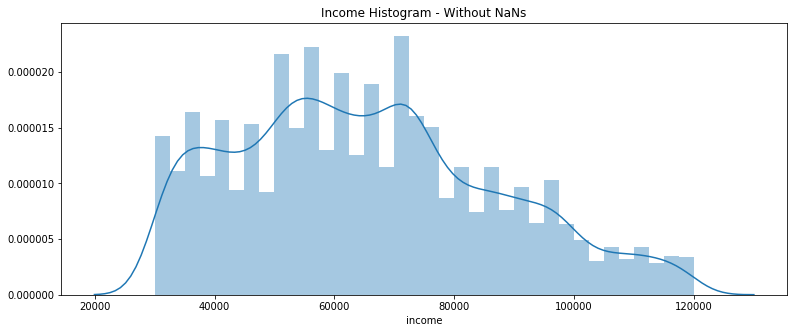

In [18]:
plt.figure(figsize = (13, 5))
sns.distplot(profile['income'].dropna());
plt.title('Income Histogram - Without NaNs');

In [19]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

By filling the `NaN`s with some value, we'll change the distribution's shape. Since both mean and median are fairly close to each other, it doesn't matter much which one we'll use.
I chose the mean.

In [20]:
processed_profile['income'].fillna(profile['income'].mean(), inplace = True)
processed_profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,Unknown,a03223e636434f42ac4c3df47e8bac43,65404.991568
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000
6,118,20170925,Unknown,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568
7,118,20171002,Unknown,68617ca6246f4fbc85e91a2a49552598,65404.991568
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000
9,118,20161122,Unknown,8974fc5686fe429db53ddde067b88302,65404.991568


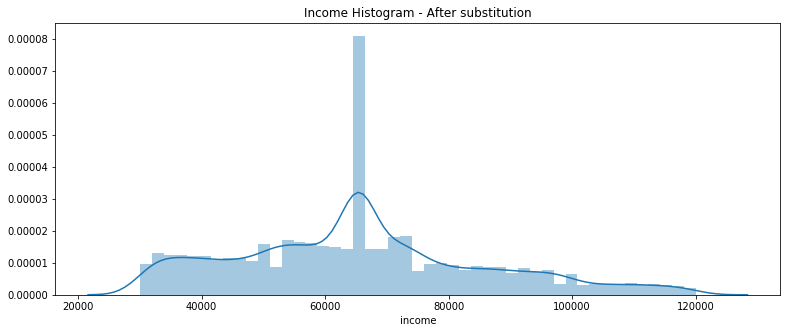

In [21]:
plt.figure(figsize = (13, 5))
sns.distplot(processed_profile['income']);
plt.title('Income Histogram - After substitution');

We can see it changed a bit the distribution of the data, but we were already expecting that.

In [22]:
processed_profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

No empty cells, looks like this dataset is good enough for now.

Another alteration we can work on is to transform the `became_member_on` column into a `datetime` object column, which allows us to work with time windows. This means that we can get the information for how long a customer has been a member of the program. Since we don't really know when those campaigns were build, we don't have a specifict point in time to measure a customer's "age" as a customer. On the other hand, we can simply use the year the user signed up for the membership.

In [23]:
def convert_to_date(date_element):
    return datetime.strptime(str(date_element), '%Y%m%d')

In [24]:
became_member_on_date = processed_profile['became_member_on'].apply(convert_to_date)

In [25]:
became_member_on_date.head()

0   2017-02-12
1   2017-07-15
2   2018-07-12
3   2017-05-09
4   2017-08-04
Name: became_member_on, dtype: datetime64[ns]

In [26]:
became_member_on_year = became_member_on_date.apply(lambda date_point: date_point.year)

In [27]:
became_member_on_year.head()

0    2017
1    2017
2    2018
3    2017
4    2017
Name: became_member_on, dtype: int64

In [28]:
processed_profile['became_member_on_year'] = became_member_on_year

In [29]:
processed_profile = processed_profile.drop(['became_member_on'], axis = 1)

In [30]:
processed_profile.head()

,age,gender,id,income,became_member_on_year
0,118,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017
2,118,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017
4,118,Unknown,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017


### `transcript` dataset preparation

In [31]:
transcript.shape

(306534, 4)

In [32]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [33]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [34]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [35]:
transcript.sample(10)

,event,person,time,value
76736,offer completed,0999506e6713408b96827816f547f0ff,186,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
8070,offer received,4972685b8b39473782a14f7709afe8b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
305497,transaction,ad18ad432f5a40c7b8ccce4be4fb530c,714,{'amount': 20.49}
147920,offer viewed,a14d4f2ec359464f8d4aeac17b755903,396,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
95745,transaction,31943ca096f1439596b2dff3da2448e0,252,{'amount': 13.9}
143173,transaction,c100c7f877fd45d7ab09717bf812dc47,378,{'amount': 2.92}
172874,offer viewed,8c20d3c8e4ef4ad997923937a2637851,420,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
166318,offer viewed,b4869c96c07e4be3aa9f2fc6027fe098,408,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
230843,offer viewed,3f0ee4aacad648a2b800641dc09003ad,534,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
284810,offer completed,760fe67c2f7f4a67b6e10fe5c8d129e3,630,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...


This dataset has no empty values. The `value` column has a dictionary that has different keys and values. It will be easier to have this column expanded into multiple columns to work with the events.

In [36]:
value_expanded = transcript['value'].apply(pd.Series)
value_expanded.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [37]:
value_expanded.sample(10)

,offer id,amount,offer_id,reward
91816,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
83549,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
182786,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
152065,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
125504,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
212858,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
240218,NaN,3.36,NaN,NaN
206141,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
104215,NaN,14.85,NaN,NaN
76467,NaN,10.31,NaN,NaN


Now that we have this matrix, we can include it to the rest of the transcript data.

In [38]:
transcript_expanded = pd.concat([transcript, value_expanded], axis = 1)
transcript_expanded.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [39]:
transcript_expanded.sample(10)

,event,person,time,value,offer id,amount,offer_id,reward
2748,offer received,bd91b42ebde945ea81af9a64685b4b79,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
301287,transaction,0922ba5634c748439e91d5c6ed793d8e,690,{'amount': 23.49},NaN,23.49,NaN,NaN
128108,transaction,dd2f15d3224349b3a54cbb4a91e89e0c,342,{'amount': 16.13},NaN,16.13,NaN,NaN
59268,offer received,8b9d3f738e7e499b9e820de07c16bc62,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
45484,transaction,3bcc51fdde354eb1949c813dbc905182,120,{'amount': 5.05},NaN,5.05,NaN,NaN
36160,transaction,0b3878783eed4009993f706e51f19d9e,72,{'amount': 14.98},NaN,14.98,NaN,NaN
187911,offer viewed,8e7a22dd150f4ecea1a6be17be1d2381,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
38931,offer viewed,79e0e0838fb4443e8fcd50efd81c0648,84,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
212318,offer received,e44d3bde10b147568f9c11fb0414abf5,504,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
208158,offer received,63bead43dc4a40f9a8da24856f98367b,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN


Now we can manipulate this dataset in order to clean it. We will deal with the duplicate `offer id`/`offer_id` column and remove unecessary columns.

The `offer id`/`offer_id` duplicates seem to relate to the same information, but for different events, which means that each line can never have two values for `offer id`/`offer_id` (only one per line). To treat that, we can create a single column thar receives the presented `offer id`/`offer_id` value when one exists.

In [40]:
transcript_expanded['offer_id_redux'] = np.where(transcript_expanded['offer id'].isnull() & transcript_expanded['offer_id'].notnull(),
                                                 transcript_expanded['offer_id'],
                                                 transcript_expanded['offer id'])
transcript_expanded.head()

,event,person,time,value,offer id,amount,offer_id,reward,offer_id_redux
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [41]:
transcript_expanded.sample(10)

,event,person,time,value,offer id,amount,offer_id,reward,offer_id_redux
49025,transaction,1c79e428cf124617aad6f62c6cf496ba,138,{'amount': 4.06},NaN,4.06,NaN,NaN,NaN
151574,offer received,1679b7af5a294c6d9ae961232318ad55,408,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
25759,transaction,0063def0f9c14bc4805322a488839b32,30,{'amount': 2.76},NaN,2.76,NaN,NaN,NaN
12170,offer received,f0ea4ff9485045ffb647a09f3b9c3063,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
172029,transaction,7b262b5d16eb491e8681f2e44106d70e,420,{'amount': 1.12},NaN,1.12,NaN,NaN,NaN
10484,offer received,37155a5f4ff248529399c95472186879,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
193664,transaction,552d9d2c23f34ce8bf2f352378b4ca46,474,{'amount': 20.31},NaN,20.31,NaN,NaN,NaN
239390,transaction,c4a3c86c7b5541cf83d443c2a89e5b5a,558,{'amount': 27.24},NaN,27.24,NaN,NaN,NaN
156872,offer received,187bc1f183174e6799994488d7b2bf2b,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
89338,transaction,a349c2f0f90c430aae70eeed8937c2fa,228,{'amount': 5.25},NaN,5.25,NaN,NaN,NaN


Now we can drop unnecessary columns.

In [42]:
transcript_expanded = transcript_expanded.drop(['value', 
                                                'offer id', 
                                                'offer_id'], 
                                               axis = 1)

In [43]:
transcript_expanded.head()

,event,person,time,amount,reward,offer_id_redux
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Exploratory Data Analysis
Starting with the `profile` dataset, we can check a bit of the age and income of the customers.

In [44]:
processed_profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

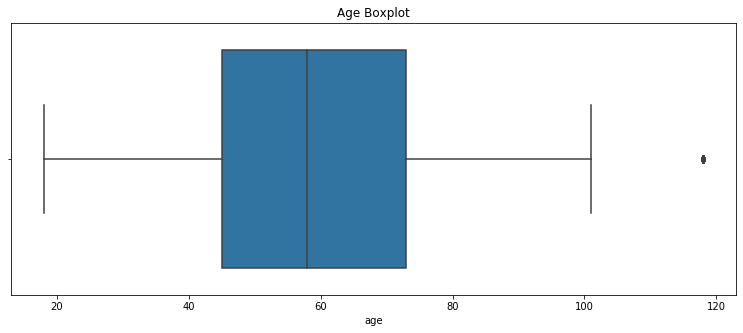

In [45]:
plt.figure(figsize = (13, 5))
sns.boxplot(processed_profile['age']);
plt.title('Age Boxplot');

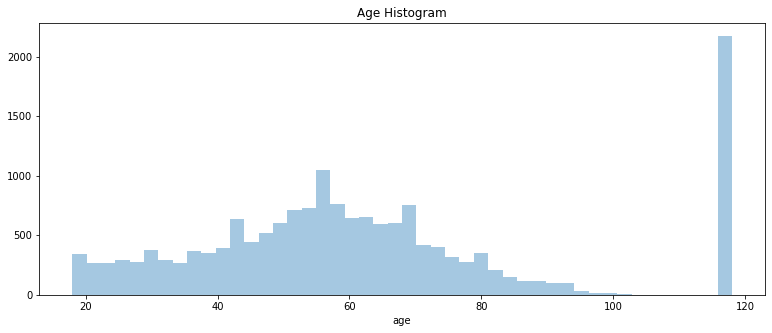

In [46]:
plt.figure(figsize = (13, 5))
sns.distplot(processed_profile['age'], kde = False);
plt.title('Age Histogram');

This histogram and the boxplot show us a great amount of outliers near 120. That was expected, since we decided not to treat the `118` values (as discussed earlier).
The users are mostly adults, with ages between 40 and 80 and the median in a bit lower than 60 (which is also lower than the mean, that is 62.5).

In [47]:
processed_profile['income'].describe()

count     17000.000000
mean      65404.991568
std       20169.288288
min       30000.000000
25%       51000.000000
50%       65404.991568
75%       76000.000000
max      120000.000000
Name: income, dtype: float64

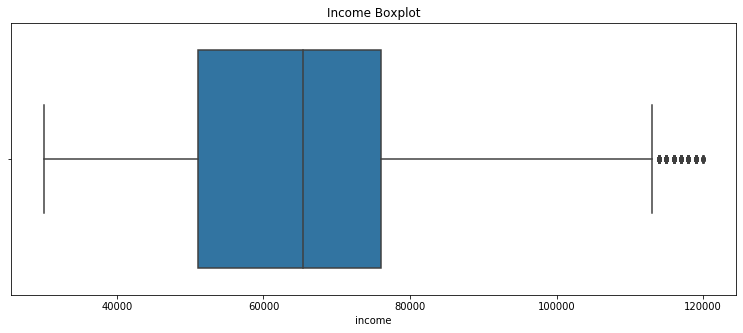

In [48]:
plt.figure(figsize = (13, 5))
sns.boxplot(processed_profile['income']);
plt.title('Income Boxplot');

We already saw the histogram for this data,the boxplot shows the distribution is a bit skewed. Mean and median seem close (around $\$65,000$) and most of the data is between $\$60,000$ and $\$75,000$.

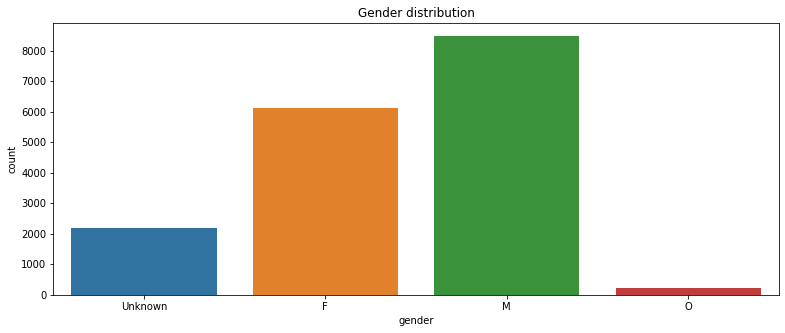

In [49]:
plt.figure(figsize = (13, 5))
sns.countplot(processed_profile['gender']);
plt.title('Gender distribution');

There are more male than females in the dataset. There is a large amount of `Unknown` and a few 'others'.

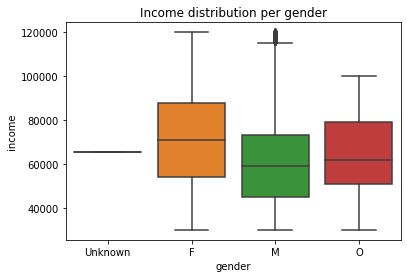

In [50]:
sns.boxplot(x = 'gender',
            y = 'income',
            data = processed_profile);
plt.title('Income distribution per gender');

The boxplots show there is no evidence that the income differs accross genders.

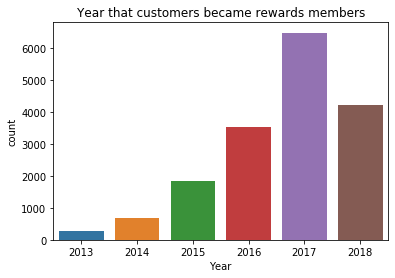

In [51]:
sns.countplot('became_member_on_year',
              data = processed_profile);
plt.title('Year that customers became rewards members')
plt.xlabel('Year');

More customers became members in 2017, followed by 2018 then 2016. The first year the with records is 2013 and it's also the year with fewer members signing for the program.

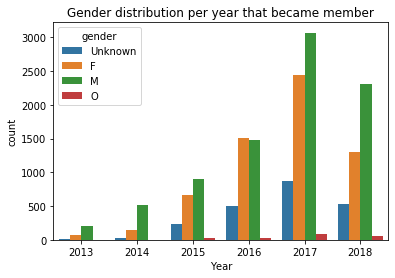

In [52]:
sns.countplot(x = 'became_member_on_year',
              hue = 'gender',
              data = processed_profile);
plt.xlabel('Year');
plt.title('Gender distribution per year that became member');

In all years, there are either more male members signing up for the program (with exception of 2016, in which there were slight more female members registrations).

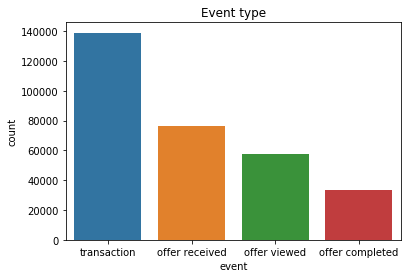

In [53]:
sns.countplot(transcript_expanded['event'],
              order = transcript_expanded['event'].value_counts().index);
plt.title('Event type');

The event type that is most frequent is `transaction`, followed by `offer received`, `offer viewed` and `offer completed`. This makes sense, since it looks like a usual customer funnel for marketing.

## Merging datasets and data preprocessing
We can get add more information to the `transcript_expanded` dataset by joining it to the `processed_portfolio` dataset, that contains information on the offers.

In [54]:
transcript_with_portfolio = transcript_expanded.merge(processed_portfolio,
                                                      how = 'left',
                                                      left_on = 'offer_id_redux',
                                                      right_on = 'id')

In [55]:
transcript_with_portfolio.head()

,event,person,time,amount,reward_x,offer_id_redux,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,1.0,1.0,1.0,1.0


In [56]:
# sort dataset by user and time, to make it easier for humans to see data
transcript_with_portfolio = transcript_with_portfolio.sort_values(['person', 'time'])

In [57]:
transcript_with_portfolio.head(50)

,event,person,time,amount,reward_x,offer_id_redux,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,1.0,1.0,1.0,1.0
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,1.0,1.0,1.0,1.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,1.0,1.0,1.0,1.0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0


In [58]:
transcript_with_portfolio.groupby(['event', 'offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

BOGO and discount offers are the inly ones with an associated `offer completed` event. Also, the `transaction` event doesn't have an associated id, which means that the join won't add data to those.

Basically, we can look into the BOGO and discount offers user funnels in this order:
* offer received
* offer viewed
* transaction
* offer completed

For the informational offer, the funnel has this order:
* offer received
* offer viewed
* transaction

This means that we have to find a way to add the transaction data into the funnel. This can be done through the user id and the timestamp. If a user didn't get to the transaction part, it won't have an `offer completed` event as well. For the informational offer, the transaction data will only exist if it came after the `offer viewed` event. The timestamp will help us find the "organic" users: users that became members regardless of the campaigns. All those scenarios can be found by ordering data by time, offer id, person and event.

In [59]:
view_to_complete = transcript_with_portfolio[['time', 'offer_id_redux', 'person', 'event']][(transcript_with_portfolio['event']=='transaction') | (transcript_with_portfolio['event'] == 'offer viewed')].groupby(['person','offer_id_redux'])

In [60]:
view_to_complete.head()

,time,offer_id_redux,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,NaN,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,NaN,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed
228422,528,NaN,0009655768c64bdeb2e877511632db8f,transaction
233413,540,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,offer viewed
237784,552,NaN,0009655768c64bdeb2e877511632db8f,transaction
258883,576,NaN,0009655768c64bdeb2e877511632db8f,transaction
85769,216,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,offer viewed


Since the dataset is grouped and ordered, we can simply fill the offer id gaps with the previous value.

In [61]:
fill_offer_id = view_to_complete['offer_id_redux'].fillna(view_to_complete['offer_id_redux'].ffill()).ffill()

In [62]:
fill_offer_id.head()

77705     5a8bc65990b245e5a138643cd4eb9837
89291     5a8bc65990b245e5a138643cd4eb9837
139992    3f207df678b143eea3cee63160fa8bed
168412    3f207df678b143eea3cee63160fa8bed
187554    f19421c1d4aa40978ebb69ca19b0e20d
Name: offer_id_redux, dtype: object

Since this column is indexed, we can join it with the original dataset and add the missing values to either one of the redundant columns (we will actually make a new column with the values for sanity check). Then drop the unnecessary columns.

In [63]:
with_full_offer_id = transcript_with_portfolio.join(fill_offer_id,
                                                    rsuffix = '_right')

In [64]:
with_full_offer_id.head()

,event,person,time,amount,reward_x,offer_id_redux,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web,offer_id_redux_right
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed


In [65]:
with_full_offer_id['offer_id'] = np.where(with_full_offer_id['offer_id_redux'].isnull(),
                                          with_full_offer_id['offer_id_redux_right'],
                                          with_full_offer_id['offer_id_redux'])

In [66]:
with_full_offer_id.head()

,event,person,time,amount,reward_x,offer_id_redux,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web,offer_id_redux_right,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed


In [67]:
with_full_offer_id = with_full_offer_id.drop(['offer_id_redux', 
                                              'offer_id_redux_right'],
                                             axis = 1)

In [68]:
with_full_offer_id.columns

Index(['event', 'person', 'time', 'amount', 'reward_x', 'difficulty',
       'duration', 'id', 'offer_type', 'reward_y', 'email', 'mobile', 'social',
       'web', 'offer_id'],
      dtype='object')

Now we can merge it again to get the transaction events data. This means we'll duplicate many columns, but all we have to do is drop them.

In [69]:
with_transaction = with_full_offer_id.merge(processed_portfolio,
                                            how = 'left',
                                            left_on = 'offer_id',
                                            right_on = 'id')

In [70]:
with_transaction.head(10)

,event,person,time,amount,reward_x,difficulty_x,duration_x,id_x,offer_type_x,reward_y,...,offer_id,difficulty_y,duration_y,id_y,offer_type_y,reward,email_y,mobile_y,social_y,web_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,...,5a8bc65990b245e5a138643cd4eb9837,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,...,5a8bc65990b245e5a138643cd4eb9837,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,...,5a8bc65990b245e5a138643cd4eb9837,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,...,3f207df678b143eea3cee63160fa8bed,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,...,3f207df678b143eea3cee63160fa8bed,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
5,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,...,f19421c1d4aa40978ebb69ca19b0e20d,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,NaN,NaN,NaN,NaN,NaN,...,3f207df678b143eea3cee63160fa8bed,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,5.0,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,...,f19421c1d4aa40978ebb69ca19b0e20d,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,...,f19421c1d4aa40978ebb69ca19b0e20d,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,...,fafdcd668e3743c1bb461111dcafc2a4,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1


In [71]:
with_transaction.columns

Index(['event', 'person', 'time', 'amount', 'reward_x', 'difficulty_x',
       'duration_x', 'id_x', 'offer_type_x', 'reward_y', 'email_x', 'mobile_x',
       'social_x', 'web_x', 'offer_id', 'difficulty_y', 'duration_y', 'id_y',
       'offer_type_y', 'reward', 'email_y', 'mobile_y', 'social_y', 'web_y'],
      dtype='object')

In [72]:
with_transaction[['reward',
                  'reward_x', 
                  'reward_y', 
                  'difficulty_x',
                  'difficulty_y',
                  'duration_x',
                  'duration_y']]

,reward,reward_x,reward_y,difficulty_x,difficulty_y,duration_x,duration_y
0,0,NaN,0.0,0.0,0,3.0,3
1,0,NaN,0.0,0.0,0,3.0,3
2,0,NaN,NaN,NaN,0,NaN,3
3,0,NaN,0.0,0.0,0,4.0,4
4,0,NaN,0.0,0.0,0,4.0,4
5,5,NaN,5.0,5.0,5,5.0,5
6,0,NaN,NaN,NaN,0,NaN,4
7,5,5.0,5.0,5.0,5,5.0,5
8,5,NaN,5.0,5.0,5,5.0,5
9,2,NaN,2.0,10.0,10,10.0,10


In [73]:
with_transaction[['reward',
                  'reward_x', 
                  'reward_y', 
                  'difficulty_x',
                  'difficulty_y',
                  'duration_x',
                  'duration_y']].isnull().sum()

reward               0
reward_x        272955
reward_y        138953
difficulty_x    138953
difficulty_y         0
duration_x      138953
duration_y           0
dtype: int64

We'll keep the `reward_y` column instead of the other ones because the lack of information there is related to the event type.

In [74]:
with_transaction.columns

Index(['event', 'person', 'time', 'amount', 'reward_x', 'difficulty_x',
       'duration_x', 'id_x', 'offer_type_x', 'reward_y', 'email_x', 'mobile_x',
       'social_x', 'web_x', 'offer_id', 'difficulty_y', 'duration_y', 'id_y',
       'offer_type_y', 'reward', 'email_y', 'mobile_y', 'social_y', 'web_y'],
      dtype='object')

In [75]:
with_transaction = with_transaction.drop(['reward',
                                          'reward_x',
                                          'difficulty_x',
                                          'duration_x',
                                          'id_x',
                                          'id_y',
                                          'offer_type_x', 
                                          'email_x',
                                          'mobile_x',
                                          'social_x', 
                                          'web_x'
                                         ],
                                         axis = 1)
with_transaction.columns

Index(['event', 'person', 'time', 'amount', 'reward_y', 'offer_id',
       'difficulty_y', 'duration_y', 'offer_type_y', 'email_y', 'mobile_y',
       'social_y', 'web_y'],
      dtype='object')

In [76]:
with_transaction = with_transaction.rename(columns = {'reward_y': 'reward',
                                                      'difficulty_y': 'difficulty',
                                                      'duration_y': 'duration',
                                                      'offer_type_y': 'offer_type',
                                                      'email_y': 'email',
                                                      'mobile_y': 'mobile',
                                                      'social_y': 'social',
                                                      'web_y': 'web'
                                                     })

In [77]:
with_transaction.head()

,event,person,time,amount,reward,offer_id,difficulty,duration,offer_type,email,mobile,social,web
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,0.0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,0.0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,0.0,3f207df678b143eea3cee63160fa8bed,0,4,informational,1,1,0,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,0.0,3f207df678b143eea3cee63160fa8bed,0,4,informational,1,1,0,1


## Finding successfull offers
### Defining success
To train the proposed models, we need to define success. For this problem, it makes sense that sucess is when a user has completed the funnels mentioned above successfully.

Let's start by finding which users got to which steps of the funnel. For that, we'll separate the events in it's own tables adn create auxiliary columns. Then we'll join those datasets to come up with a single dataset that has the offer id, the person id, and three booleans for received, viewed and completed. We'll also include the considerations for the order of the performed events to be considered valid in this step.

In [78]:
def creating_event_df(original_df, event):
    '''
    this function takes in a dataframe that contains the 'event', 
    'person' and 'time' columns and creates a new dataframe for only 
    one selected event sorted by people and time.
    
    INPUT
    - original_df (df): dataframe that contains the 'event', 
      'person' and 'time' columns
    - event (str): the target event
    
    OUTPUT
    - target_df (df): sorted dataframe with the desired filters
    '''
    target_df = original_df[original_df['event'] == event].copy()
    target_df.sort_values(['person', 'time'])
    
    return target_df

In [79]:
offer_received = creating_event_df(with_transaction, 'offer received')

offer_received.rename(columns = {'time': 'time_received'},
                      inplace = True)

offer_received = offer_received.drop(['event',
                                      'amount',
                                      'difficulty',
                                      'offer_type',
                                      'email',
                                      'mobile',
                                      'social',
                                      'web'],
                                     axis = 1)

offer_received['received'] = np.ones(len(offer_received))

offer_received.head()

,person,time_received,reward,offer_id,duration,received
0,0009655768c64bdeb2e877511632db8f,168,0.0,5a8bc65990b245e5a138643cd4eb9837,3,1.0
3,0009655768c64bdeb2e877511632db8f,336,0.0,3f207df678b143eea3cee63160fa8bed,4,1.0
5,0009655768c64bdeb2e877511632db8f,408,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0
9,0009655768c64bdeb2e877511632db8f,504,2.0,fafdcd668e3743c1bb461111dcafc2a4,10,1.0
14,0009655768c64bdeb2e877511632db8f,576,2.0,2906b810c7d4411798c6938adc9daaa5,7,1.0


In [80]:
offer_viewed = creating_event_df(with_transaction, 'offer viewed')

offer_viewed.rename(columns = {'time': 'time_viewed'},
                    inplace = True)

offer_viewed = offer_viewed.drop(['event',
                                  'amount',
                                  'reward',
                                  'duration',
                                  'difficulty',
                                  'offer_type',
                                  'email',
                                  'mobile',
                                  'social',
                                  'web'],
                                axis = 1)

offer_viewed['viewed'] = np.ones(len(offer_viewed))

offer_viewed.head()

,person,time_viewed,offer_id,viewed
1,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,1.0
4,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,1.0
8,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,1.0
12,0009655768c64bdeb2e877511632db8f,540,fafdcd668e3743c1bb461111dcafc2a4,1.0
21,00116118485d4dfda04fdbaba9a87b5c,216,f19421c1d4aa40978ebb69ca19b0e20d,1.0


In [81]:
offer_transaction = creating_event_df(with_transaction, 'transaction')

offer_transaction.rename(columns = {'time': 'time_transaction'},
                         inplace = True)

offer_transaction = offer_transaction.drop(['event',
                                            'reward',
                                            'duration',
                                            'difficulty',
                                            'offer_type',
                                            'email',
                                            'mobile',
                                            'social',
                                            'web'],
                                           axis = 1)

offer_transaction['has_transaction'] = np.ones(len(offer_transaction))

offer_transaction.head()

,person,time_transaction,amount,offer_id,has_transaction
2,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,1.0
6,0009655768c64bdeb2e877511632db8f,414,8.57,3f207df678b143eea3cee63160fa8bed,1.0
10,0009655768c64bdeb2e877511632db8f,528,14.11,f19421c1d4aa40978ebb69ca19b0e20d,1.0
13,0009655768c64bdeb2e877511632db8f,552,13.56,fafdcd668e3743c1bb461111dcafc2a4,1.0
15,0009655768c64bdeb2e877511632db8f,576,10.27,fafdcd668e3743c1bb461111dcafc2a4,1.0


In [82]:
offer_completed = creating_event_df(with_transaction, 'offer completed')

offer_completed.rename(columns = {'time': 'time_completed'},
                       inplace = True)

offer_completed = offer_completed.drop(['event',
                                        'amount',
                                        'reward',
                                        'duration',
                                        'difficulty',
                                        'offer_type',
                                        'email',
                                        'mobile',
                                        'social',
                                        'web'],
                                      axis = 1)

offer_completed['completed'] = np.ones(len(offer_completed))

offer_completed.head()

,person,time_completed,offer_id,completed
7,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,1.0
11,0009655768c64bdeb2e877511632db8f,528,fafdcd668e3743c1bb461111dcafc2a4,1.0
16,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1.0
33,0011e0d4e6b944f998e987f904e8c1e5,252,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0
41,0011e0d4e6b944f998e987f904e8c1e5,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0


In [83]:
# merge event dataframes into one
offers_received_viewed = offer_received.merge(offer_viewed,
                                              how = 'left',
                                              on = ['person', 'offer_id'])

offers_received_viewed_transaction = offers_received_viewed.merge(offer_transaction,
                                                                  how = 'left',
                                                                  on = ['person', 'offer_id'])

offers = offers_received_viewed_transaction.merge(offer_completed,
                                                  how = 'left',
                                                  on = ['person', 'offer_id'])

# reorder columns
offers = offers[['person',
                 'offer_id', 
                 'received', 
                 'viewed', 
                 'has_transaction',
                 'completed', 
                 'duration', 
                 'time_received',
                 'time_viewed',
                 'time_transaction',
                 'time_completed',
                 'amount',
                 'reward']]

# add expiration time for the offer
offers['time_expiry'] = offers['duration'] + offers['time_received']

In [84]:
offers.head()

,person,offer_id,received,viewed,has_transaction,completed,duration,time_received,time_viewed,time_transaction,time_completed,amount,reward,time_expiry
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,NaN,3,168,192.0,228.0,NaN,22.16,0.0,171
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,1.0,1.0,NaN,4,336,372.0,414.0,NaN,8.57,0.0,340
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,5,408,456.0,528.0,414.0,14.11,5.0,413
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,10,504,540.0,552.0,528.0,13.56,2.0,514
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,10,504,540.0,576.0,528.0,10.27,2.0,514


In [85]:
# filter only pairs of events and person where the 
# funnel order was followed correctly and the offer
# was successful
successful_offers = offers[(offers['has_transaction'] == 1) &                          # the offer must have had a transaction
                           (offers['time_transaction'] >= offers['time_viewed']) &     # the moment the transaction happened must be after the offer was viewed
                           (offers['time_viewed'] >= offers['time_received']) &        # the moment the offer was viewed must be after the offer was received
                           ((offers['time_expiry'] < offers['time_completed']) |       # the offers must have been completed - either by transaction in the case
                           (offers['time_expiry'] < offers['time_transaction']))]      ## informational offers or by event - before the expiration time

# add a column of ones signaling those are sucessful offers
successful_offers['is_successful'] = np.ones(len(successful_offers))

/home/julia.tessler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [86]:
successful_offers.shape

(217659, 15)

In [87]:
# filter only pairs of events and person where the 
# funnel order was followed correctly but the offer 
# was not successful
non_successful_offers = offers[offers['has_transaction'].isna()]      # if the offer has no transaction, it wasn't successful

# add a column of ones signaling those are sucessful offers
non_successful_offers['is_successful'] = np.zeros(len(non_successful_offers))

/home/julia.tessler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [88]:
non_successful_offers.shape

(27573, 15)

Now we can merge it back into one dataset and then merge this data with the rest of the profile data.

In [89]:
offers = successful_offers.merge(non_successful_offers,
                                how = 'outer')

In [90]:
offers.shape

(245232, 15)

We also need to refine user data. Let's start by joining the `profile` data with the transactions.

In [91]:
len(offers['person'].unique())

16993

In [92]:
len(processed_profile['id'].unique())

17000

In [93]:
len(with_transaction['person'].unique())

17000

The amount of distinct users in our `offers` data isn't the same as it is in the `profile` data, which means there is a chance we have most of our offers covered by the `profile` data.

The `offers` dataset has 245,232 rows.

In [94]:
selected_users_profile = offers['person'].isin(processed_profile['id'])
selected_users_offers = offers[selected_users_profile]

In [95]:
selected_users = with_transaction['person'].isin(selected_users_offers['person'])
selected_transactions = with_transaction[selected_users]

In [96]:
selected_transactions = selected_transactions.drop(['event',
                                                    'time'], axis = 1)
selected_transactions.head()

,person,amount,reward,offer_id,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,NaN,0.0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,NaN,0.0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,NaN,0.0,3f207df678b143eea3cee63160fa8bed,0,4,informational,1,1,0,1
4,0009655768c64bdeb2e877511632db8f,NaN,0.0,3f207df678b143eea3cee63160fa8bed,0,4,informational,1,1,0,1


In [97]:
selected_transactions.shape

(306508, 11)

Now we have to filter this dataset only for the successful or non-successful offers we found above.

In [98]:
successful_transactions = offers.merge(selected_transactions,
                                       how = 'inner',
                                       right_on = ['person', 'offer_id'],
                                       left_on = ['person', 'offer_id'])

In [99]:
successful_transactions.columns

Index(['person', 'offer_id', 'received', 'viewed', 'has_transaction',
       'completed', 'duration_x', 'time_received', 'time_viewed',
       'time_transaction', 'time_completed', 'amount_x', 'reward_x',
       'time_expiry', 'is_successful', 'amount_y', 'reward_y', 'difficulty',
       'duration_y', 'offer_type', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [100]:
successful_transactions = successful_transactions.drop(['reward_x',
                                                        'received', 
                                                        'viewed', 
                                                        'has_transaction',
                                                        'completed',
                                                        'duration_x', 
                                                        'time_received', 
                                                        'time_viewed',
                                                        'time_transaction',
                                                        'time_completed',
                                                        'amount_x', 
                                                        'time_expiry',
                                                       ],
                                                       axis = 1)

successful_transactions.rename(columns = {'reward_y': 'reward',
                                          'duration_y': 'duration',
                                          'amount_y': 'amount'},
                         inplace = True)

successful_transactions.head(20)

,person,offer_id,is_successful,amount,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,0.0,0,3,informational,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,0.0,0,3,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,22.16,NaN,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,0.0,0,4,informational,1,1,0,1
4,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,0.0,0,4,informational,1,1,0,1
5,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,8.57,NaN,0,4,informational,1,1,0,1
6,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,NaN,5.0,5,5,bogo,1,1,1,1
7,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,NaN,5.0,5,5,bogo,1,1,1,1
8,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,NaN,5.0,5,5,bogo,1,1,1,1
9,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,14.11,NaN,5,5,bogo,1,1,1,1


In [101]:
successful_transactions.shape

(2472021, 12)

Now we have multiple lines for the same successful transaction. Let's leave only one line of informations for each person and offer pair.

In [102]:
successful_transactions = successful_transactions.drop_duplicates()
successful_transactions.head()

,person,offer_id,is_successful,amount,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,0.0,0,3,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,22.16,NaN,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,0.0,0,4,informational,1,1,0,1
5,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,8.57,NaN,0,4,informational,1,1,0,1
6,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,NaN,5.0,5,5,bogo,1,1,1,1


We still have some duplicates due to the multiple lines related to events... Since the `amount` column only happens when a user makes a transaction, this feature is highly important to predict the success because it's part of the definition of success. Therefore, it can't be used in the model and should be dropped.

In [103]:
transactions_logs = successful_transactions.drop(['amount'], axis = 1)

transactions_logs = transactions_logs.dropna().drop_duplicates()

In [104]:
transactions_logs.shape

(62398, 11)

In [105]:
transactions_logs.head(20)

,person,offer_id,is_successful,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,0.0,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,0.0,0,4,informational,1,1,0,1
6,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5.0,5,5,bogo,1,1,1,1
10,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,2.0,10,10,discount,1,1,1,1
50,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5.0,5,5,bogo,1,1,1,1
71,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1.0,0.0,0,4,informational,1,1,0,1
74,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,3.0,7,7,discount,1,1,1,1
78,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5.0,5,7,bogo,1,1,0,1
96,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1.0,2.0,10,10,discount,1,1,1,1
168,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,10.0,10,5,bogo,1,1,1,1


Now we can join the user data with the transaction logs.

In [106]:
transactions_with_users = transactions_logs.merge(processed_profile,
                                                  how = 'left',
                                                  left_on = 'person',
                                                  right_on = 'id')

In [107]:
transactions_with_users.columns

Index(['person', 'offer_id', 'is_successful', 'reward', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'age',
       'gender', 'id', 'income', 'became_member_on_year'],
      dtype='object')

Cool! Now we're almost ready to start modelling. To model data, we need to remove the `person`/`id` and `offer_id` columns as well as encode the `offer_type` and `gender` (we'll use [Scikit-learn's `LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for this). The `amount` coly

In [108]:
final_dataset = transactions_with_users.drop(['person',
                                              'offer_id',
                                              'id'],
                                             axis = 1)

In [109]:
le = LabelEncoder()

In [110]:
offer_types_list = list(final_dataset['offer_type'].unique())
types_encoder = le.fit(offer_types_list)
offer_type_encoded = le.transform(final_dataset['offer_type'])

final_dataset['offer_type_encoded'] = offer_type_encoded

In [111]:
gender_list = list(final_dataset['gender'].unique())
gender_encoder = le.fit(gender_list)
gender_encoded = le.transform(final_dataset['gender'])

final_dataset['gender_encoded'] = gender_encoded

In [112]:
final_dataset.head(20)

,is_successful,reward,difficulty,duration,offer_type,email,mobile,social,web,age,gender,income,became_member_on_year,offer_type_encoded,gender_encoded
0,1.0,0.0,0,3,informational,1,1,1,0,33,M,72000.000000,2017,2,1
1,1.0,0.0,0,4,informational,1,1,0,1,33,M,72000.000000,2017,2,1
2,1.0,5.0,5,5,bogo,1,1,1,1,33,M,72000.000000,2017,0,1
3,1.0,2.0,10,10,discount,1,1,1,1,33,M,72000.000000,2017,1,1
4,1.0,5.0,5,5,bogo,1,1,1,1,118,Unknown,65404.991568,2018,0,3
5,1.0,0.0,0,4,informational,1,1,0,1,40,O,57000.000000,2018,2,2
6,1.0,3.0,7,7,discount,1,1,1,1,40,O,57000.000000,2018,1,2
7,1.0,5.0,5,7,bogo,1,1,0,1,40,O,57000.000000,2018,0,2
8,1.0,2.0,10,10,discount,1,1,1,1,59,F,90000.000000,2016,1,0
9,1.0,10.0,10,5,bogo,1,1,1,1,59,F,90000.000000,2016,0,0


In [113]:
final_dataset = final_dataset.drop(['offer_type',
                                    'gender'], axis = 1)

In [114]:
final_dataset.columns

Index(['is_successful', 'reward', 'difficulty', 'duration', 'email', 'mobile',
       'social', 'web', 'age', 'income', 'became_member_on_year',
       'offer_type_encoded', 'gender_encoded'],
      dtype='object')

In [115]:
final_dataset.isna().sum()

is_successful            0
reward                   0
difficulty               0
duration                 0
email                    0
mobile                   0
social                   0
web                      0
age                      0
income                   0
became_member_on_year    0
offer_type_encoded       0
gender_encoded           0
dtype: int64

In [116]:
final_dataset.shape

(62398, 13)

In [141]:
final_dataset.head()

,is_successful,reward,difficulty,duration,email,mobile,social,web,age,income,became_member_on_year,offer_type_encoded,gender_encoded
0,1.0,0.0,0,3,1,1,1,0,33,72000.000000,2017,2,1
1,1.0,0.0,0,4,1,1,0,1,33,72000.000000,2017,2,1
2,1.0,5.0,5,5,1,1,1,1,33,72000.000000,2017,0,1
3,1.0,2.0,10,10,1,1,1,1,33,72000.000000,2017,1,1
4,1.0,5.0,5,5,1,1,1,1,118,65404.991568,2018,0,3


## Modeling
### Separating data into train and test
We'll use [Scikit-learn's `train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to separate data, with 80% as train and 20% as test.

Our independent variables - or features - will be:
* reward
* difficulty
* duration
* email
* mobile
* social
* web
* amount
* age
* income
* became_member_on_year
* offer_type_encoded
* gender_encoded

We'll train supervised models for this. Our dependent variable will be `is_successful`. 

The supervised models that will be trained are:
* Model 1: Logistic Regression
* Model 2: Naïve Bayes
* Model 3: Support Vector Machines (SVM)
* Model 4: Decision Tree

We'll use Scikit-learn's framework for all models.

In [117]:
features = final_dataset[['reward', 
                          'difficulty', 
                          'duration',
                          'email', 
                          'mobile',
                          'social',
                          'web', 
                          'age',
                          'income', 
                          'became_member_on_year',
                          'offer_type_encoded',
                          'gender_encoded']]

y = final_dataset['is_successful']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    y, 
                                                    test_size = 0.8, 
                                                    random_state = 42)

To train all models, we'll use [Scikit-learn's `cross_val_score`](https://scikit-learn.org/stable/modules/cross_validation.html) with 5 folds.

### Baseline model
As baseline model we'll use a naive one, given by [Scikit-learn's `DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). The model shall predict by most frequent class.

In [119]:
dummy_clf = DummyClassifier(strategy = "most_frequent")

cross_val_baseline = cross_val_score(dummy_clf, 
                                     X_train, 
                                     y_train, 
                                     cv = 5, 
                                     scoring = 'f1_micro')

In [120]:
cross_val_baseline.mean()

0.6441221316975467

The baseline model has 64.41% of F1-Score. We're looking for models that can perform better than this one.

### Model 1: Logistic Regression
Since this is a small dataset, we'll use the `liblinear` solver as suggested by [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

The logistic regression is a fairly simple model that presents good results in robust datasets, such as this one. We expect it to be better than the baseline and, since this is one of the most explainable models there is, we might favor it depending on the results.

In [121]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42)

cross_val_lr = cross_val_score(lr, 
                               X_train, 
                               y_train, 
                               cv = 5, 
                               scoring = 'f1_micro')

In [122]:
cross_val_lr.mean()

0.6662358493158751

We can see some marginal gain in the F1-Score: this model reached 66.62%.

### Model 2: Naïve Bayes
We'll train a Gaussian Näive Bayes model. This model usually performs well in well defined classification models. The chosen classifier, Gaussian, assumes that the likelihood of the features comes from a Gaussian distribution (see [documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) for more details).

Even though this is a naïve model, it can perform very well for this type of problem, even when the data breaks the Gaussian assumption.

In [123]:
nb = GaussianNB()

cross_val_nb = cross_val_score(nb, 
                               X_train, 
                               y_train, 
                               cv = 5, 
                               scoring = 'f1_micro')

In [124]:
cross_val_nb.mean()

0.702621055986057

This model performed a bit better than the Logistic Regression and baseline models when it comes to F1-Score: 70.26%.

### Model 3: Support Vector Machines (SVM)
We'll train support vector machines. SVMs are considered more complex than the models above. We expect it to perform better than the baseline, buti it might start to overfit the model.

In [125]:
sv = svm.SVC()

cross_val_sv = cross_val_score(sv, 
                               X_train, 
                               y_train, 
                               cv = 5, 
                               scoring = 'f1_micro')

/home/julia.tessler/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/julia.tessler/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/julia.tessler/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/julia.tessler/anaconda3/lib/

In [126]:
cross_val_sv.mean()

0.6510127408915569

This model has 65.10% of F1-Score. It is better than the baseline model, but not better than the Naïve Bayes model.

### Model 4: Decision Tree
We'll train a decision tree classifier. This is the most powerful of all the chosen models and is very likely to overfit.

In [127]:
dt = DecisionTreeClassifier(random_state = 42)

cross_val_dt = cross_val_score(dt, 
                               X_train, 
                               y_train, 
                               cv = 5, 
                               scoring = 'f1_micro')

In [128]:
cross_val_dt.mean()

0.6508533831240313

This better than the baseline model, since the F1-Score is 65.08%. But it's not the best.

## Choosing the best model
Based on the resuls we found above, the best model is the Naïve Bayes. Let's retrain it so we can keep it's coefficients and apply it to the test features.

In [129]:
model = nb.fit(X_train, y_train)

In [130]:
predictions = model.predict(X_test)

In [131]:
# get the confusion matrix
pd.crosstab(y_test, predictions)

col_0,0.0,1.0
is_successful,,
0.0,6095,12012
1.0,3097,28715


In [132]:
metrics.f1_score(y_test, predictions, average = 'micro')

0.6973296740719966

In [133]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.66      0.34      0.45     18107
         1.0       0.71      0.90      0.79     31812

    accuracy                           0.70     49919
   macro avg       0.68      0.62      0.62     49919
weighted avg       0.69      0.70      0.67     49919



The model performed not very well in the test dataset, reaching a 69.73% F1-Score. The decrease in the score was already expected, since this data is new to the model.

The other usual metrics performed fairly well, with exception of the recall for non-successful offers, which was 34% - meaning that it's prediction is worse than flipping a coin to predict the success of the offer.

Unfortunatelly, Naïve Bayes model do not have easy explanations for the coefficients, which means that we can't easily explain what variables are related to the success of the offer. What we can do is look into each variable and the associated probability to look into the relations.

In [134]:
result_df = pd.DataFrame(X_train.columns)
result_df[['non successful', 'successful']] = pd.DataFrame(model.predict_proba(X_train).tolist())

result_df

,0,non successful,successful
0,reward,0.204731,0.795269
1,difficulty,0.925091,0.074909
2,duration,0.346706,0.653294
3,email,0.294267,0.705733
4,mobile,0.408526,0.591474
5,social,0.093768,0.906232
6,web,0.924745,0.075255
7,age,0.337013,0.662987
8,income,0.398634,0.601366
9,became_member_on_year,0.288445,0.711555


Also we can get the features that had the most predictive contribution to each class, but still no explainability.

In [135]:
# source: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# prints the top 10 most predictive features for the non-successful class
neg = model.theta_[0].argsort()
print(np.take(X_train.columns, neg[:10]))

print('')

# prints the top 10 most predictive features for the successful class
neg = model.sigma_[0].argsort()
print(np.take(X_train.columns, neg[:10]))

Index(['social', 'mobile', 'web', 'gender_encoded', 'offer_type_encoded',
       'email', 'reward', 'duration', 'difficulty', 'age'],
      dtype='object')

Index(['email', 'web', 'mobile', 'social', 'offer_type_encoded',
       'gender_encoded', 'became_member_on_year', 'duration', 'reward',
       'difficulty'],
      dtype='object')


If we consider the Logist Regression as the best explainable model, we can look into the coefficients to get the most important features.

In [136]:
model_lr = lr.fit(X_train, y_train)

In [137]:
predictions_lr = model_lr.predict(X_test)

In [138]:
metrics.f1_score(y_test, predictions_lr, average = 'micro')

0.6438029607964904

In [139]:
# get the confusion matrix
pd.crosstab(y_test, predictions_lr)

col_0,0.0,1.0
is_successful,,
0.0,523,17584
1.0,197,31615


In [140]:
# Logistic Regression needs a small transformation to get the right coefficients
transformed_coefficients = list(np.exp(model_lr.coef_))
cdf = pd.DataFrame(list(X_train.columns), transformed_coefficients).reset_index()

cdf.columns = ['coefficient', 'feature']
print(cdf.sort_values(by = 'coefficient', ascending = False))

    coefficient                feature
0      1.051222                 reward
5      1.023997                 social
4      1.008203                 mobile
9      1.000550  became_member_on_year
3      1.000011                  email
8      0.999996                 income
11     0.999768         gender_encoded
7      0.998785                    age
6      0.995864                    web
2      0.992067               duration
10     0.987936     offer_type_encoded
1      0.960984             difficulty


The supervised models trained, with respective F1-Scores, were:
* Baseline Model: Dummy Classifier for most frequent class
    * F1-Score: 64.41%
* Model 1: Logistic Regression
    * F1-Score: 66.62%
* Model 2: Naïve Bayes
    * F1-Score: 70.26%
* Model 3: Support Vector Machines (SVM)
    * 65.10%
* Model 4: Decision Tree
    * F1-Score: 65.08%

The best model was Naïve Bayes, but it has not explainability. The second best and explainable model was the Logistic Regression.

In order to have explainability, we loose predictive power: the F1-Score of the Logistic Regression model is 64.38%. But the value of the reward, followed by the offer sent by social networks. For the increase of one unit in each feature, we expect a increase of the respective coefficient in the success of the offer.

## Conclusion
When we started, we wanted to make better purchasing offers to Starbucks’ customers. For
this, we used customer’s past behaviour to find patterns and try to be more assertive. As given
by the Udacity’s Starbucks Project Overview, the basic task was to use the data to identify which
groups of people are most responsive to each type of offer, and how best to present each type of
offer. In other words, this is a classification problem where the model takes user behaviour data as
input and produces a group as output (either previously defined or not).

For this project, we spent quite some time dealing with the features, manipulating tose to fit into the models. For that to happen, we found a way to define an offer success based on the user funnel performed from the transcript dataset.

Once we had the dataset, we trained 4 supervised learning models and a baseline one. The baseline was a incredibly naïve model that classified the items based on the most frequent class. The model with best performance was a Naïve Bayes. This model doesn't have easy explainability, which means we fail to find understainable patterns to provide offers.

In order to get explainability, we chose the Logistic Regression model, that has lower predictive power. But with this model, we identified the top three most important features: reward, social and mobile.

Next steps would include better feature engineering and selection (we just used all features we could) and other classification models. The model selection should probably account for model explainability, which failed in this case. 